In [3]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


In [4]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [5]:
df = pd.read_csv("./medical-ai-main/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [6]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [7]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [8]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [9]:
rootdir = "./medical-ai-main/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [10]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [11]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

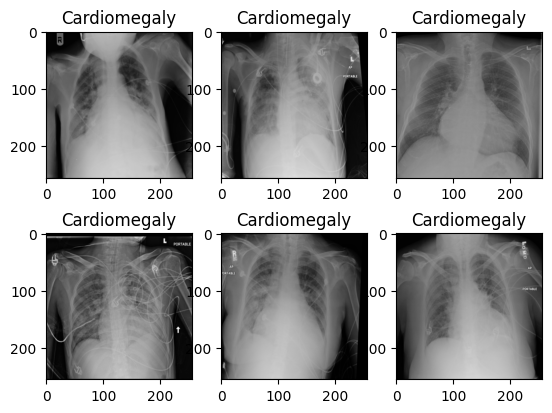

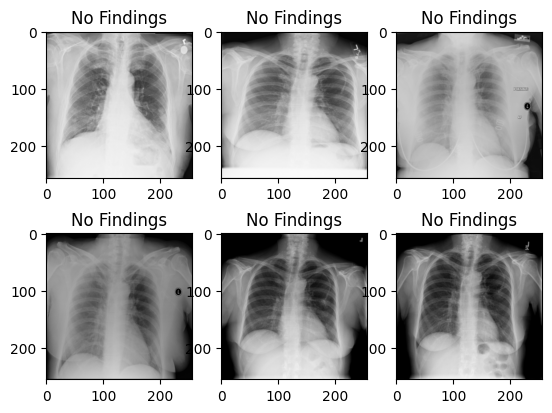

In [12]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [13]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x) # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

Done compiling the model!


In [14]:
# Define our example directories and files
base_dir = rootdir = "./medical-ai-main/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [15]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
print("Done funneling data!")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Done funneling data!


In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=1,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

232/232 - 585s - loss: 9.5890 - acc: 0.5991 - val_loss: 1.1441 - val_acc: 0.7833 - 585s/epoch - 3s/step


In [1]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


NameError: name 'history' is not defined

In [19]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [20]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 123ms/step
Done inference!


In [21]:
df.head()

,filepath,filename,label,guess,confidence
0,./medical-ai-main/images/Cardiomegaly\test\pos...,00004344_013.jpg,pos,pos,1.000000
1,./medical-ai-main/images/Cardiomegaly\test\pos...,00004533_014.jpg,pos,pos,1.000000
2,./medical-ai-main/images/Cardiomegaly\test\pos...,00013615_052.jpg,pos,pos,1.000000
3,./medical-ai-main/images/Cardiomegaly\test\pos...,00025969_000.jpg,pos,pos,0.999991
4,./medical-ai-main/images/Cardiomegaly\test\pos...,00008522_032.jpg,pos,pos,0.999954


1/1 [==============================] - 0s 157ms/step


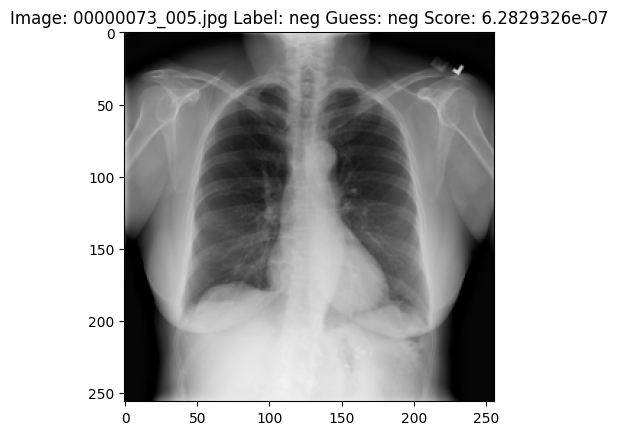

In [22]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])


1/1 [==============================] - 0s 138ms/step


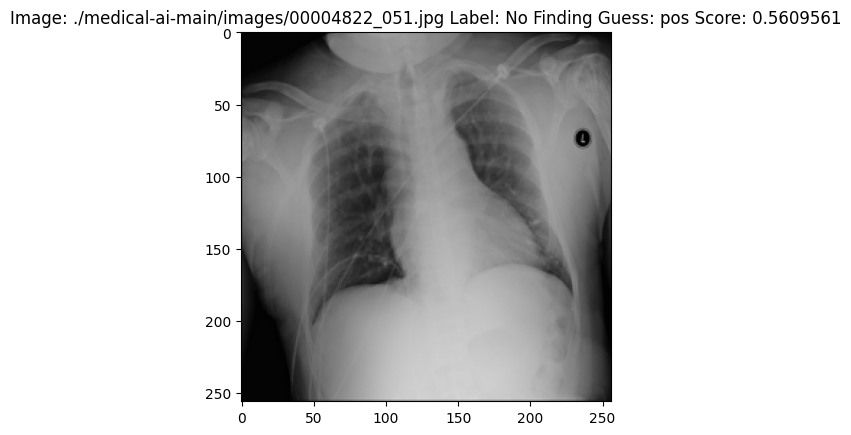

In [23]:
image_path = './medical-ai-main/images/00004822_051.jpg'
image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
img = load_image_into_numpy_array(image)
exp = np.true_divide(img, 255.0)
expanded = np.expand_dims(exp, axis=0)
pred = model.predict(expanded)[0][0]
guess = "neg"
if pred > 0.5:
    guess = "pos"
title = "Image: "+image_path+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
plt.title(title)
plt.imshow(img)
plt.show()

In [24]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00004344_013.jpg,pos,pos,1.000000e+00
5,00011557_003.jpg,pos,pos,9.999245e-01
10,00010381_000.jpg,pos,pos,9.987191e-01
15,00000080_000.jpg,neg,pos,9.955805e-01
20,00008399_007.jpg,pos,pos,9.834393e-01
25,00015064_001.jpg,pos,pos,8.821180e-01
30,00004822_051.jpg,pos,pos,5.609561e-01
35,00019861_010.jpg,pos,neg,2.638418e-01
40,00000090_001.jpg,neg,neg,5.985517e-03
45,00000086_000.jpg,neg,neg,2.085545e-04


In [25]:
cutoff = 0.79 #@param {type:"slider", min:0, max:1, step:0.01}

In [26]:
# def create_with_cutoff(cutoff):
#   __, ax = plt.subplots()
#   TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
#   FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
#   FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
#   TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
#   plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
#            edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
#            stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
#            label=['TP','FP','TN','FN'])
#   plt.xlabel('Confidence')
#   plt.ylabel('N')
#   plt.xticks(bins)
#   ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#   plt.title('Confidence scores for different values')
#   plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
#   plt.legend(loc="lower right", fontsize=16)
#   sens = round(len(TP)/(len(TP)+len(FN)),2)
#   spec = round(len(TN)/(len(TN)+len(FP)),2)
#   stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
#   plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
#   plt.show()

# create_with_cutoff(cutoff)

In [27]:
# model.save('/content/export/'+finding)
# !zip -r /content/{finding}.zip /content/export/{finding}

In [48]:
from tensorflow.python.saved_model.save import save


model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [50]:
import tensorflowjs

!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve './saved_model/my_model/keras_metadata.pb' './webmodel'

Traceback (most recent call last):
  File "C:\Users\ranja\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\ranja\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\ranja\AppData\Roaming\Python\Python310\Scripts\tensorflowjs_converter.exe\__main__.py", line 7, in <module>
  File "C:\Users\ranja\AppData\Roaming\Python\Python310\site-packages\tensorflowjs\converters\converter.py", line 827, in pip_main
    main([' '.join(sys.argv[1:])])
  File "C:\Users\ranja\AppData\Roaming\Python\Python310\site-packages\tensorflowjs\converters\converter.py", line 831, in main
    convert(argv[0].split(' '))
  File "C:\Users\ranja\AppData\Roaming\Python\Python310\site-packages\tensorflowjs\converters\converter.py", line 817, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "C:\Users

In [2]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import os

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

# tf.keras.models.save_model(
#     model,
#     export_path,
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None
# )

# print('\nSaved model:')
# !ls -l {export_path}

export_path = C:\Users\ranja\AppData\Local\Temp\1



In [6]:
import sys

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -


'tee' is not recognized as an internal or external command,
operable program or batch file.
